In [2]:
# Lets load some librarues and car data and precalculated features
library(dplyr)
library(ggplot2)
library(glmnet)
library(corrplot)

load("data/fsecure.train.RData"); kori.class<-class

Warning message:
“package ‘dplyr’ was built under R version 3.3.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggplot2’ was built under R version 3.3.2”Warning message:
“package ‘glmnet’ was built under R version 3.3.2”Loading required package: Matrix
Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.3.2”Loaded glmnet 2.0-5



In [3]:
head(autodata)

ajoneuvoluokka,ryhma,ajoneuvonkaytto,kayttoonottoVuosi,matkamittarilukema,vari,kori,kori.orig,kori.est,omamassa,⋯,suurinNettoteho,polttoaine,kuntanimi,Co2,Co2.orig,Co2.modelled,merkki,mallimerkinta,l.malli,malli
Henkilöauto,Henkilö,Yksityinen,1997,355890,Vihreä,Farmari,Farmari,Farmari,1320,⋯,66,Bensiini,Kouvola,205.3317,NA,205.3317,VOLKSWAGEN,5D PASSAT VARIANT 1.8 CL-351-C/263,PASSAT,PASSAT
Henkilöauto,Henkilö,Yksityinen,1984,NA,Ruskea,Viistoperä,NA,Viistoperä,780,⋯,NA,Bensiini,Oulu,179.9998,NA,179.9998,FORD,2D FIESTA 1.1-FBD/2280,FIESTA,FIESTA
Henkilöauto,Henkilö,Myyntivarasto,1990,NA,Valkoinen,Sedan,NA,Sedan,1060,⋯,88,Bensiini,Helsinki,204.1334,NA,204.1334,CITROEN,4D SEDAN BX 19 GTI-XBEY/2650,BX,BX
Henkilöauto,Henkilö,Yksityinen,2003,108731,Punainen,Viistoperä,Viistoperä,Viistoperä,955,⋯,43,Bensiini,Pori,143.0000,143,142.4133,RENAULT,2D CLIO HATCHBACK 1.2-CB0FCF/247,CLIO,CLIO
Henkilöauto,Henkilö,Yksityinen,2003,238435,Sininen,Sedan,Sedan,Sedan,1462,⋯,114,Bensiini,Tampere,190.0000,190,190.5217,HONDA,4D ACCORD SEDAN 2.0-CL75/268,ACCORD,ACCORD
Henkilöauto,Henkilö,Yksityinen,2006,109030,Hopea,Farmari,Farmari,Farmari,1270,⋯,81,Bensiini,Ähtäri,172.0000,172,171.8726,TOYOTA,5D COROLLA STW 1.6-ZZE121L-DWMNKW/260,COROLLA,COROLLA


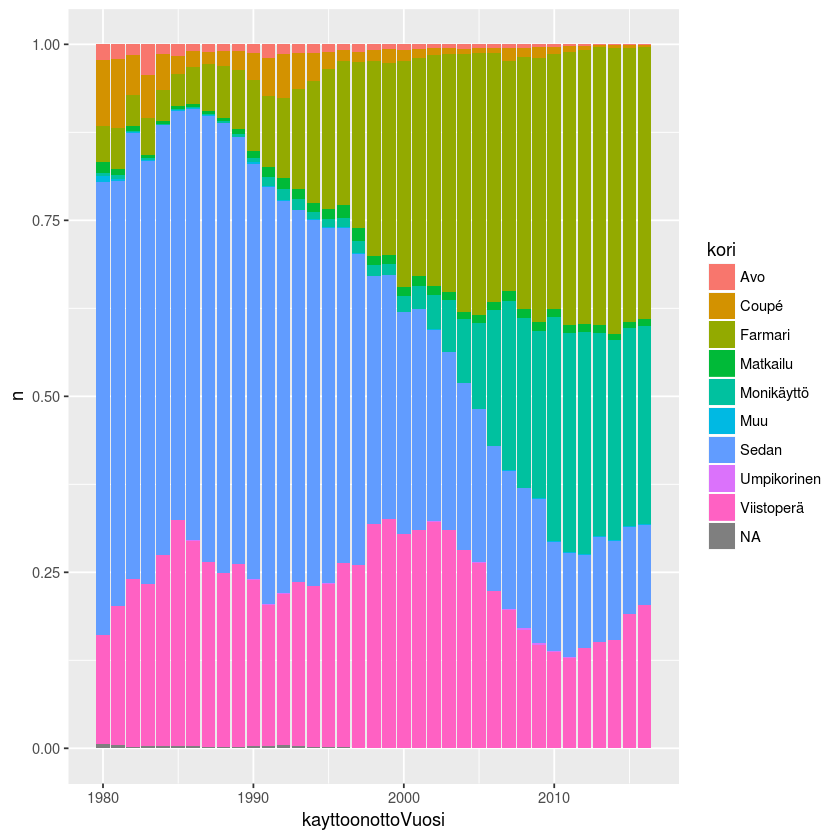

In [79]:
# Let's see the car type; there's plenty of missing data

filter(autodata,kayttoonottoVuosi>1979) %>% 
count(.,kori,kayttoonottoVuosi) %>% 
ggplot(.,aes(x=kayttoonottoVuosi,y=n,fill=kori))+geom_bar(stat="identity")

In [17]:
# autodata contains a field kori.orig that is the original car type and 
# kori.est that has a prediction on the car type (sedan, wagon, ...)
# It's made using the brand and model information string, and a tree classifier (xgboost). 

select(autodata,merkki,mallimerkinta,kori.orig,kori.est) %>% head

# Prediction accuracy (percentage)
mean(autodata$kori.est == autodata$kori.orig,na.rm=TRUE)*100

merkki,mallimerkinta,kori.orig,kori.est
VOLKSWAGEN,5D PASSAT VARIANT 1.8 CL-351-C/263,Farmari,Farmari
FORD,2D FIESTA 1.1-FBD/2280,NA,Viistoperä
CITROEN,4D SEDAN BX 19 GTI-XBEY/2650,NA,Sedan
RENAULT,2D CLIO HATCHBACK 1.2-CB0FCF/247,Viistoperä,Viistoperä
HONDA,4D ACCORD SEDAN 2.0-CL75/268,Sedan,Sedan
TOYOTA,5D COROLLA STW 1.6-ZZE121L-DWMNKW/260,Farmari,Farmari


is.na(kori.orig),n
FALSE,2206514
TRUE,457711


[1] 99.76438

In [80]:

# Let's demonstrate LASSO regulatized regression, cross-validation, and 

# X contains a sparse matrix where data "merkki+mallimerkinta" is divided by space and some punctuation 
# 5D PASSAT VARIANT 1.8 CL-351-C/263 => [5D, PASSAT, VARIANT, 1.8, CL, 351, C/263]
# and one-hot-coded into a sparse matrix X and class vector c
#
# This has been done elsewhere, and rows with missing class kori.orig are omitted

head(X)
head(class)

# lets make it a bit smaller, and take a 5% sample
sample.idx<-seq(1, dim(X)[1], 20)
select.vars<-colSums(X)>10

dim(X)
dim(X[sample.idx,select.vars])

   [[ suppressing 34 column names ‘’, ‘NA’, ‘5OV’ ... ]]


6 x 40219 sparse Matrix of class "dgCMatrix"
                                                                             
2  1 1 . 1 1 1 1 1 1 1 1 1 . . . . . . . . . . . . . . . . . . . . . . ......
3  1 1 . . . . . . . . . 1 1 1 1 1 1 1 1 1 1 . . . . . . . . . . . . . ......
5  1 1 . . . . . . . . . . . . . . . . . . . . 1 1 1 1 1 1 . . . . . . ......
8  1 1 . . . . . 1 1 1 . . . . . . . . . . . . . . . . . . 1 1 . . . . ......
10 1 1 1 . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . ......
11 1 1 . . . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . . ......

 .....suppressing columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

[1] "Matkailu" "Coupé"    "Matkailu" "Matkailu" "Matkailu" "Sedan"

[1] 70498 40219

[1] 3525 2527

In [81]:
# Multinomial classification, ten folds, LASSO
classifier <-cv.glmnet(X[sample.idx, select.vars],
             as.factor(kori.class[sample.idx]),
             type.measure="deviance",
             family="multinomial",
             alpha=1,
             nfolds=10)


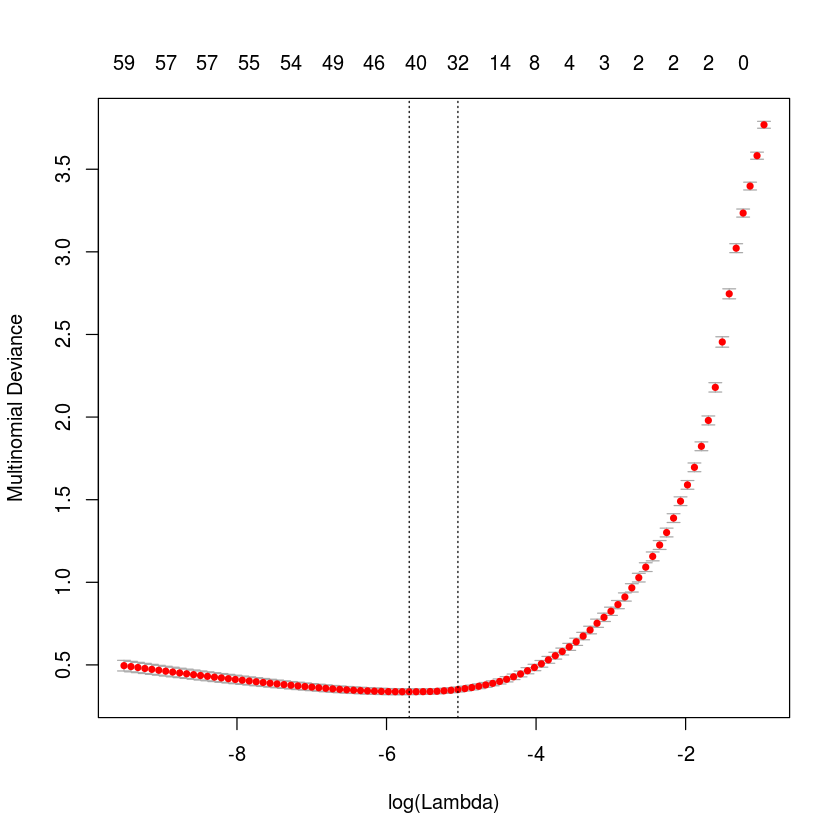

In [82]:
# Lets see some statistics (deviation is not =classification error)
plot(classifier)

In [83]:
#Lets predict using the best model and see the accuracy!

mean(kori.class == predict(classifier, X[,select.vars], type="class"))*100

[1] 96.15166

In [88]:
# Let's see the confusion matrix!
# kori.orig (true car type) is capitalized
options(scipen=999)

table(toupper(class), predict(lasso.model,X[,select.vars], type="class")) %>% 
  prop.table(.,1) 


            
                       Avo         Coupé       Farmari      Matkailu
  AVO        0.96230954290 0.00641539695 0.00320769848 0.00060144346
  COUPÉ      0.00185687759 0.94929295815 0.00085702043 0.00057134695
  FARMARI    0.00000000000 0.00016768207 0.97797775418 0.00139735062
  MATKAILU   0.00012470383 0.00000000000 0.00336700337 0.94974435715
  MONIKÄYTTÖ 0.00014587892 0.00000000000 0.03894967177 0.01458789205
  MUU        0.00855614973 0.00000000000 0.01818181818 0.02352941176
  SEDAN      0.00065530799 0.00202549744 0.00125104254 0.00017872036
  VIISTOPERÄ 0.00024928331 0.00174498317 0.00174498317 0.00137105821
            
                Monikäyttö           Muu         Sedan    Viistoperä
  AVO        0.00060144346 0.00000000000 0.02626303128 0.00060144346
  COUPÉ      0.00014283674 0.00000000000 0.03970861306 0.00757034709
  FARMARI    0.00503046224 0.00005589402 0.01470012856 0.00067072830
  MATKAILU   0.01035041776 0.00336700337 0.03304651453 0.00000000000
  MONIKÄ

In [89]:
# Lets see the coefficients 

coef(lasso.model)$Sedan

2528 x 1 sparse Matrix of class "dgCMatrix"
                               1
(Intercept)         0.5021775144
                    .           
NA                  .           
5OV                 .           
160                 .           
MULTIJET            .           
PÖSSL               .           
MATKAILUAUTO        .           
SA                  .           
3OV                 .           
2999CM3             .           
A                   .           
2D                  .           
HT                  .           
COUPE               .           
COUPÉ               .           
AD                  .           
2OV                 .           
5750CM3             .           
590CM3              .           
D                   .           
570                 .           
E                   .           
ADRIATIK            .           
2464CM3             .           
CORAL               .           
680                 .           
SP                  .           

In [91]:
# Let's see this a bit better
cf<-coef(lasso.model)$Farmari
data.frame(attr=rownames(cf), coef=as.numeric(cf)) %>% 
arrange(-coef)


attr,coef
FRMRI,3.3419425
5D,3.0419848
AC,2.9420168
FARMARI,2.7300385
300L,2.7230377
123,2.3544875
850CM3,2.1215716
BREAK,2.0610815
4X4/237,1.8485952
410,1.8485688
